<a href="https://colab.research.google.com/github/AmirMiraki/INF367-GDL-Project-2/blob/main/GDL_project2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

First you need add a shortcut of data in your google drive from [here](https://drive.google.com/drive/folders/1YNnDxEvc6B5-EdyIUK4EpFqtSovF0lpD?usp=sharing)

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# Package requirments

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
import torchvision

import copy

import cv2
import os


# Device configuration
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Dataset 

In [ ]:
# Dataset defination
class StereoImageDataset(Dataset):
    def __init__(self, data_dir, transform=None):
        self.X = np.load(data_dir +'X.npy')
        self.y = np.load(data_dir +'y.npy')
        self.transform = transform
        
    def __len__(self):
        return len(self.y)
        
    def __getitem__(self, idx):
        imgL =self.X[idx,0,:,:,:]
        imgL = cv2.resize(imgL,(400,400))
        imgR = self.X[idx,1,:,:,:]
        imgR = cv2.resize(imgR,(400,400))
        if self.transform:
            imgL = self.transform(imgL[:,:,2])
            imgR = self.transform(imgR[:,:,2])
        if self.y[idx] == 'sunny':
          label = torch.tensor([0], dtype=torch.float32)
        else:
          label = torch.tensor([1], dtype=torch.float32)
        return imgL, imgR , label

In [ ]:
data_dir = '/content/drive/MyDrive/'
transform = transforms.Compose([
    transforms.ToTensor()
])

dataset = StereoImageDataset(data_dir, transform=transform)


In [ ]:
# Hyper-parameters
num_epochs = 30
batch_size = 10
learning_rate = 0.00001

torch.manual_seed(10)
criterion = nn.BCELoss() # Binary Classification Entropy


In [ ]:
# train test spliting
train_dataset, test_dataset = torch.utils.data.random_split(dataset, [int(len(dataset)*0.8), int(len(dataset)*0.2)])
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=True)

image illustrator

In [ ]:
def imshow(img):
    plt.figure()
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2,0)))
    plt.show()

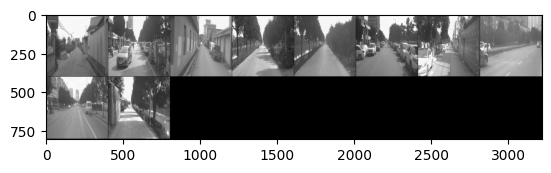

In [ ]:
# get some random training images
dataiter = iter(train_loader)
imgL, imgR, labels = next(dataiter)

# show images
imshow(torchvision.utils.make_grid(imgL))


# Group action defination

## Here is the the C4 group action ang=[0,90,180,270]

In [ ]:
def rho(x,ang):
    y = transforms.functional.rotate(x,ang)
    return y

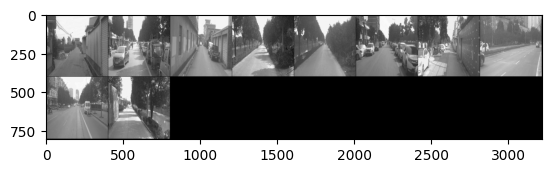

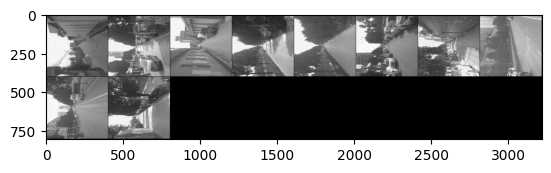

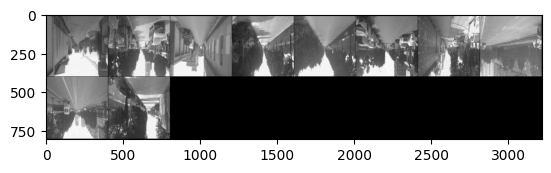

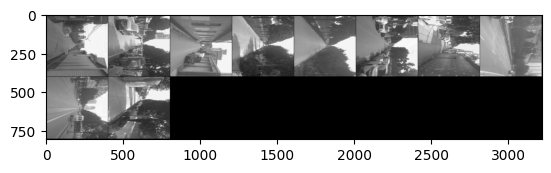

In [ ]:
# Testing with the example
# P4 group
for i in [0,90,180,270]:
  imshow(torchvision.utils.make_grid(rho(imgR,i)))

# Basic Model

basic model designed by three 2D-conv layer and two Fully connected layer.

last layer activation function σ

In [ ]:
# We make a function that can check how different to tensors are
def differ(x,y,des=3):
    return np.round(torch.max(torch.abs(y-x)).item(),des)

In [ ]:
#Basic Model
class sc_class(nn.Module):
    def __init__(self,Test=False,ang=90):
        super(sc_class, self).__init__()
        self.Test = Test
        self.ang = ang
        self.conv1 = nn.Conv2d(1, 3, kernel_size=7, stride=1, padding=3)
        self.conv2 = nn.Conv2d(3, 6, kernel_size=5, stride=1, padding=2)
        self.pool1 = nn.MaxPool2d(kernel_size=2, stride=2)
        self.conv3 = nn.Conv2d(6, 12, kernel_size=3, stride=1, padding=1)
        self.pool2 = nn.MaxPool2d(kernel_size=2, stride=2)
        self.fc1 = nn.Linear(12*100*100, 256)
        self.fc2 = nn.Linear(256, 1)
        
    def forward(self, x):
        # 1 x 400 x 400
        if self.Test:
            y = rho(x,self.ang)
            D=[]
        # Convolution layer
        x = self.conv1(x) # 3 x 400 x 400
        if self.Test:
            y = self.conv1(y)
            D.append(differ(rho(x,self.ang),y))
        
        x = nn.functional.relu(x)
        # Convolution layer
        x = self.conv2(x) # 6 x 400 x 400
        if self.Test:
            y = nn.functional.relu(y)
            y = self.conv2(y)
            D.append(differ(rho(x,self.ang),y))
        
        x = nn.functional.relu(x)
        # Local pooling
        x = self.pool1(x) # 6 x 200 x 200
        # Convolution layer
        x = self.conv3(x) # 12 x 200 x 200
        if self.Test:
            y = nn.functional.relu(y)
            y = self.pool1(y)
            y = self.conv3(y)
            D.append(differ(rho(x,self.ang),y))
        
        x = nn.functional.relu(x)
        # Local pooling
        x = self.pool2(x) # 12 x 100 x 100
        # Global pooling
        x = torch.flatten(x, 1)
        x = self.fc1(x)
        
        
        if self.Test:
            y = nn.functional.relu(y)
            y = self.pool2(y)
            y = torch.flatten(y, 1)
            y = self.fc1(y)
            D.append(differ(x,y)) # Testing invariance
            print(D)
            self.Test = False
        x = nn.functional.relu(x)
        x = self.fc2(x)
        return nn.functional.sigmoid(x)


In [ ]:
model = sc_class().to(device)
optimizer = optim.Adam(model.parameters(), lr=learning_rate)

train and evaluate Basic model 

In [ ]:
test_lossL_c=[]
test_lossR_c=[]
test_loss_rot_c=[]
for epoch in range(num_epochs):
    # Train the model
    if epoch%5==0: #Testing equvarency every 5 epoch
        model.Test=True 
    model.train()
    train_loss = 0.0
    
    for imgL, imgR , Labels in train_loader:
        optimizer.zero_grad()
        outputs = model(imgL.to(device))
        loss = criterion(outputs, Labels.to(device))
        loss.backward()
        optimizer.step()
        train_loss += loss.item() * imgL.size(0)
    
    train_loss /= len(train_dataset)
    
    # then evaluation
    model.eval()
    test_lossL = 0.0
    test_lossR = 0.0
    test_loss_rot = 0.0
    with torch.no_grad():
        for imgL, imgR, Labels in test_loader:
            outputsL = model(imgL.to(device))
            lossL = criterion(outputsL, Labels.to(device))
            test_lossL += lossL.item() * imgR.size(0)

            outputsR = model(imgR.to(device))
            lossR = criterion(outputsR, Labels.to(device))
            test_lossR += lossR.item() * imgR.size(0)

            outputs2 = model(rho(imgR.to(device),90))
            loss2 = criterion(outputs2, Labels.to(device))
            test_loss_rot += loss2.item() * imgR.size(0)
    
    test_lossL /= len(test_dataset)
    test_lossR /= len(test_dataset)
    test_loss_rot /= len(test_dataset)
    
    #store history curve
    test_lossL_c.append(test_lossL)
    test_lossR_c.append(test_lossR)
    test_loss_rot_c.append(test_loss_rot)

    print(f'Epoch {epoch+1}/{num_epochs}, Train Loss: {train_loss:.4f}, Test Loss L: {test_lossL:.4f}, Test Loss R: {test_lossR:.4f}, G Test Loss : {test_loss_rot:.4f}')
    

[0.972, 0.553, 0.269, 0.065]
Epoch 1/30, Train Loss: 0.6828, Test Loss L: 0.6813, Test Loss R: 0.6819, G Test Loss : 0.6933
Epoch 2/30, Train Loss: 0.6660, Test Loss L: 0.6677, Test Loss R: 0.6690, G Test Loss : 0.6900
Epoch 3/30, Train Loss: 0.6411, Test Loss L: 0.6179, Test Loss R: 0.6223, G Test Loss : 0.6585
Epoch 4/30, Train Loss: 0.6166, Test Loss L: 0.6050, Test Loss R: 0.6102, G Test Loss : 0.6532
Epoch 5/30, Train Loss: 0.5920, Test Loss L: 0.5727, Test Loss R: 0.5812, G Test Loss : 0.6399
[0.977, 0.575, 0.274, 0.62]
Epoch 6/30, Train Loss: 0.5695, Test Loss L: 0.5518, Test Loss R: 0.5624, G Test Loss : 0.6342
Epoch 7/30, Train Loss: 0.5466, Test Loss L: 0.5447, Test Loss R: 0.5573, G Test Loss : 0.6300
Epoch 8/30, Train Loss: 0.5288, Test Loss L: 0.5172, Test Loss R: 0.5336, G Test Loss : 0.6219
Epoch 9/30, Train Loss: 0.5013, Test Loss L: 0.5158, Test Loss R: 0.5368, G Test Loss : 0.6219
Epoch 10/30, Train Loss: 0.4840, Test Loss L: 0.4747, Test Loss R: 0.4978, G Test Loss :

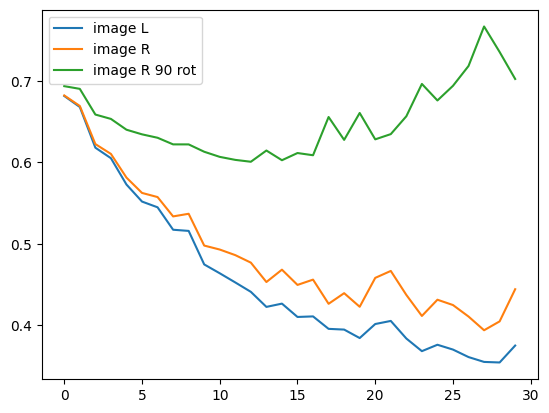

In [ ]:
plt.figure()
plt.plot(np.array(test_lossL_c))
plt.plot(np.array(test_lossR_c))
plt.plot(np.array(test_loss_rot_c))
plt.legend(['image L','image R','image R 90 rot'])
plt.show()

# Group-Smoothing approach on Conv. layers

In [ ]:
# Convolution with forced equivariance
class GroupConv(nn.Module):
    def __init__(self, in_channels, out_channels, kernel_size, stride=1, padding=0):
        super(GroupConv, self).__init__()
        self.conv = nn.Conv2d(in_channels, out_channels, kernel_size, stride=stride, padding=padding)

    def forward(self, x):
      out = self.conv(x)
      for i in [90,180,270]:
        out += rho(self.conv(rho(x,i)),-i)
      return out/4

In [ ]:
class sc_class_smooth(nn.Module):
    def __init__(self,Test=False,ang=90):
        super(sc_class_smooth, self).__init__()
        self.Test = Test
        self.ang = ang
        self.conv1 = GroupConv(1, 3, kernel_size=7, stride=1,padding=3)
        self.conv2 = GroupConv(3, 6, kernel_size=5, stride=1,padding=2)
        self.pool1 = nn.MaxPool2d(kernel_size=2, stride=2)
        self.conv3 = GroupConv(6, 12, kernel_size=3, stride=1,padding=1)
        self.pool2 = nn.MaxPool2d(kernel_size=2, stride=2)
        self.fc1 = nn.Linear(12*100*100, 256)
        self.fc2 = nn.Linear(256, 1)
        
    
    def forward(self, x):
        # 1 x 400 x 400
        # Convolution layer
        if self.Test:
            y = rho(x,self.ang)
            D=[]
        x = self.conv1(x) # 3 x 400 x 400
        x = nn.functional.relu(x)
        if self.Test:
            y = self.conv1(y)
            y = nn.functional.relu(y)
            D.append(differ(rho(x,self.ang),y))
        # Nonlinear
        
        # Convolution layer
        x = self.conv2(x) # 6 x 400 x 400
        if self.Test:
            y = self.conv2(y)
            D.append(differ(rho(x,self.ang),y))
        # Nonlinear
        x = nn.functional.relu(x)
        # Local pooling
        x = self.pool1(x)
        # Convolution layer
        x = self.conv3(x) # 12 x 200 x 200
        if self.Test:
            y = nn.functional.relu(y)
            y = self.pool1(y)
            y = self.conv3(y)
            D.append(differ(rho(x,self.ang),y))
        # Nonlinear
        x = nn.functional.relu(x)
        # Local pooling
        x = self.pool2(x) # 12 x 100 x 100
        # Global pooling
        # x = InvPoolG(x)
        x = torch.flatten(x, 1)
        x = self.fc1(x)
        # Nonlinear
        
        if self.Test:
            y = nn.functional.relu(y)
            y = self.pool2(y)
            # y = InvPoolG(y)
            y = torch.flatten(y, 1)
            y = self.fc1(y)
            D.append(differ(x,y)) # Testing invariance
            print(D)
            self.Test = False
        x = nn.functional.relu(x)
        x = self.fc2(x)
        return nn.functional.sigmoid(x)


In [ ]:
model1 = sc_class_smooth().to(device)
optimizer = optim.Adam(model1.parameters(), lr=learning_rate)

train and evaluate smooth model

In [ ]:
test_loss_c=[]
test_loss_rot_s_c=[]
for epoch in range(num_epochs):
    if epoch%5==0: 
        model1.Test=True #Testing equvarency every 5 epoch
    # Train the model
    model1.train()
    train_loss = 0.0
    
    for imgL, imgR , Labels in train_loader:
        optimizer.zero_grad()
        outputs = model1(imgL.to(device))
        loss = criterion(outputs, Labels.to(device))
        loss.backward()
        optimizer.step()
        train_loss += loss.item() * imgL.size(0)
    
    train_loss /= len(train_dataset)
    
    # then evaluation
    model1.eval()
    test_loss = 0.0
    test_loss_rot = 0.0
    with torch.no_grad():
        for imgL, imgR, Labels in test_loader:
            outputs = model1(imgR.to(device))
            loss = criterion(outputs, Labels.to(device))
            test_loss += loss.item() * imgR.size(0)

            outputs2 = model1(rho(imgR.to(device),90))
            loss2 = criterion(outputs2, Labels.to(device))
            test_loss_rot += loss2.item() * imgR.size(0)
            
    
    test_loss /= len(test_dataset)
    test_loss_rot /= len(test_dataset)

    test_loss_c.append(test_loss)
    test_loss_rot_s_c.append(test_loss_rot)
    print(f'Epoch {epoch+1}/{num_epochs}, Train Loss: {train_loss:.4f}, Test Loss: {test_loss:.4f}, G Test Loss : {test_loss_rot:.4f}')
    

[0.0, 0.0, 0.0, 0.043]
Epoch 1/30, Train Loss: 0.6944, Test Loss: 0.6928, G Test Loss : 0.6935
Epoch 2/30, Train Loss: 0.6918, Test Loss: 0.6914, G Test Loss : 0.6932
Epoch 3/30, Train Loss: 0.6894, Test Loss: 0.6910, G Test Loss : 0.6941
Epoch 4/30, Train Loss: 0.6891, Test Loss: 0.6851, G Test Loss : 0.6909
Epoch 5/30, Train Loss: 0.6841, Test Loss: 0.6822, G Test Loss : 0.6904
[0.0, 0.0, 0.0, 0.612]
Epoch 6/30, Train Loss: 0.6792, Test Loss: 0.6745, G Test Loss : 0.6862
Epoch 7/30, Train Loss: 0.6757, Test Loss: 0.6736, G Test Loss : 0.6882
Epoch 8/30, Train Loss: 0.6696, Test Loss: 0.6629, G Test Loss : 0.6827
Epoch 9/30, Train Loss: 0.6668, Test Loss: 0.6571, G Test Loss : 0.6814
Epoch 10/30, Train Loss: 0.6597, Test Loss: 0.6525, G Test Loss : 0.6814
[0.0, 0.0, 0.0, 0.89]
Epoch 11/30, Train Loss: 0.6543, Test Loss: 0.6533, G Test Loss : 0.6841
Epoch 12/30, Train Loss: 0.6475, Test Loss: 0.6454, G Test Loss : 0.6830
Epoch 13/30, Train Loss: 0.6405, Test Loss: 0.6299, G Test Loss :

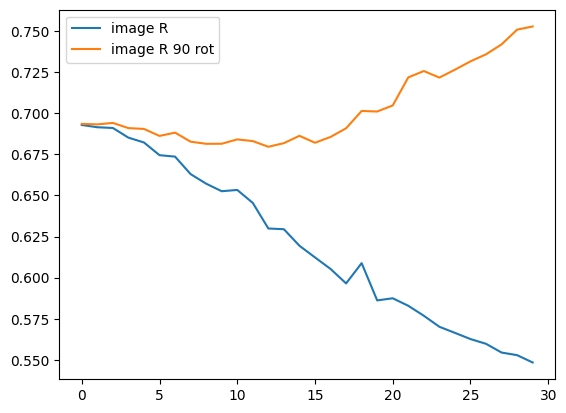

In [ ]:
plt.figure()
plt.plot(np.array(test_loss_c))
plt.plot(np.array(test_loss_rot_s_c))
plt.legend(['image R','image R 90 rot'])
plt.show()

# Group-equvariant layer 

In [ ]:
# We define it according to our group, with (i,j) representing S^i_{Hor} @ S^j_{Var}
class GroupConvInit(nn.Module):
    def __init__(self, in_channels, out_channels, kernel_size, stride=1, padding=0):
        super(GroupConvInit, self).__init__()
        
        # For 2d-convolution being as descibed above, we need to have no bias
        self.conv00 = nn.Conv2d(in_channels, out_channels, kernel_size, stride=stride, padding=padding,bias=False)
        self.conv10 = nn.Conv2d(in_channels, out_channels, kernel_size, stride=stride, padding=padding,bias=False)
        self.conv01 = nn.Conv2d(in_channels, out_channels, kernel_size, stride=stride, padding=padding,bias=False)
        self.conv11 = nn.Conv2d(in_channels, out_channels, kernel_size, stride=stride, padding=padding,bias=False)
        
        weight = self.conv00.weight
        
        self.conv10.weight = nn.Parameter(rho(weight,90))
        self.conv01.weight = nn.Parameter(rho(weight,180))
        self.conv11.weight = nn.Parameter(rho(weight,270))
        
        

    def forward(self, x):
        out00 = self.conv00(x)
        out10 = self.conv10(x)
        out01 = self.conv01(x)
        out11 = self.conv11(x)
        return torch.stack((out00,out10,out01,out11),dim=-3)

max poolling function

In [ ]:
def MaxPoolG0(x):
    y = torch.max(x,dim=-3)[0]
    return y

# implement invariant network

Invariant Poolling 

In [ ]:
def InvPoolG(x):
    out0 = rho(x,0)
    out90 = rho(x,90)
    out180 = rho(x,180)
    out270 = rho(x,270)
    return (out0+out90+out180+out270)

Group-equvariant layer ⇒ Conv. smoothing approach layer ⇒ usual 2D-conv. layer

In [ ]:
class sc_classGDL(nn.Module):
    def __init__(self,Test=False,ang=90):
        super(sc_classGDL, self).__init__()
        self.Test = Test
        self.ang = ang
        self.conv1 = GroupConvInit(1, 3, kernel_size=7, stride=1,padding=3)
        self.conv2 = GroupConv(3, 6, kernel_size=5, stride=1,padding=2)
        self.pool1 = nn.MaxPool2d(kernel_size=2, stride=2)
        self.conv3 = nn.Conv2d(6, 12, kernel_size=3, stride=1,padding=1)
        self.pool2 = nn.MaxPool2d(kernel_size=2, stride=2)
        self.fc1 = nn.Linear(12*100*100, 256)
        self.fc2 = nn.Linear(256, 1)
        
    
    def forward(self, x):
        # 1 x 400 x 400
        if self.Test:
            y = rho(x,self.ang)
            D=[]
        # Convolution layer
        x = self.conv1(x) # 3 x 400 x 400
        # Nonlinear
        x = nn.functional.relu(x)
        x = MaxPoolG0(x)
        if self.Test:
            y = self.conv1(y)
            y = nn.functional.relu(y)
            y = MaxPoolG0(y)
            D.append(differ(rho(x,self.ang),y))
        
        # Convolution layer
        x = self.conv2(x) # 6 x 400 x 400
        if self.Test:
            y = self.conv2(y)
            D.append(differ(rho(x,self.ang),y))
        # Nonlinear
        x = nn.functional.relu(x)
        # Local pooling
        x = self.pool1(x)
        # Convolution layer
        x = self.conv3(x) # 12 x 200 x 200
        if self.Test:
            y = nn.functional.relu(y)
            y = self.pool1(y)
            y = self.conv3(y)
            D.append(differ(rho(x,self.ang),y))
        # Nonlinear
        x = nn.functional.relu(x)
        # Local pooling
        x = self.pool2(x) # 12 x 100 x 100
        x = InvPoolG(x)
        # Global pooling
        x = torch.flatten(x, 1)
        x = self.fc1(x)
        # Nonlinear
        
        if self.Test:
            y = nn.functional.relu(y)
            y = self.pool2(y)
            y = InvPoolG(y)
            y = torch.flatten(y, 1)
            y = self.fc1(y)
            D.append(differ(x,y)) # Testing invariance
            print(D)
            self.Test = False
        x = nn.functional.relu(x)
        x = self.fc2(x)
        return nn.functional.sigmoid(x)


In [ ]:
model2 = sc_classGDL().to(device)
optimizer = optim.Adam(model2.parameters(), lr=learning_rate)

train and evaluate invariant model

In [ ]:
test_loss_c=[]
test_loss_rot_gdl_c=[]
for epoch in range(num_epochs):
    if epoch%5==0:
        model2.Test=True #Testing equvarency every 5 epoch
    # Train the model
    model2.train()
    train_loss = 0.0
    
    for imgL, imgR , Labels in train_loader:
        optimizer.zero_grad()
        outputs = model2(imgL.to(device))
        loss = criterion(outputs, Labels.to(device))
        loss.backward()
        optimizer.step()
        train_loss += loss.item() * imgL.size(0)
    
    train_loss /= len(train_dataset)
    
    # then evaluation
    model2.eval()
    test_loss = 0.0
    test_loss_rot = 0.0
    with torch.no_grad():
        for imgL, imgR, Labels in test_loader:
            outputs = model2(imgR.to(device))
            loss = criterion(outputs, Labels.to(device))
            test_loss += loss.item() * imgR.size(0)

            outputs2 = model2(rho(imgR.to(device),90))
            loss2 = criterion(outputs2, Labels.to(device))
            test_loss_rot += loss2.item() * imgR.size(0)
            
    
    test_loss /= len(test_dataset)
    test_loss_rot /= len(test_dataset)

    test_loss_c.append(test_loss)
    test_loss_rot_gdl_c.append(test_loss_rot)
    print(f'Epoch {epoch+1}/{num_epochs}, Train Loss: {train_loss:.4f}, Test Loss: {test_loss:.4f}, G Test Loss : {test_loss_rot:.4f}')
    

[0.0, 0.0, 0.311, 0.015]
Epoch 1/30, Train Loss: 0.6909, Test Loss: 0.6809, G Test Loss : 0.6812
Epoch 2/30, Train Loss: 0.6764, Test Loss: 0.6833, G Test Loss : 0.6831
Epoch 3/30, Train Loss: 0.6662, Test Loss: 0.6469, G Test Loss : 0.6477
Epoch 4/30, Train Loss: 0.6528, Test Loss: 0.6310, G Test Loss : 0.6323
Epoch 5/30, Train Loss: 0.6399, Test Loss: 0.6149, G Test Loss : 0.6167
[0.037, 0.011, 0.277, 0.044]
Epoch 6/30, Train Loss: 0.6278, Test Loss: 0.6032, G Test Loss : 0.6043
Epoch 7/30, Train Loss: 0.6185, Test Loss: 0.5912, G Test Loss : 0.5930
Epoch 8/30, Train Loss: 0.6156, Test Loss: 0.5844, G Test Loss : 0.5876
Epoch 9/30, Train Loss: 0.6065, Test Loss: 0.5793, G Test Loss : 0.5829
Epoch 10/30, Train Loss: 0.6042, Test Loss: 0.5743, G Test Loss : 0.5783
[0.1, 0.029, 0.269, 0.105]
Epoch 11/30, Train Loss: 0.5952, Test Loss: 0.5685, G Test Loss : 0.5707
Epoch 12/30, Train Loss: 0.5833, Test Loss: 0.5567, G Test Loss : 0.5624
Epoch 13/30, Train Loss: 0.5721, Test Loss: 0.5509, 

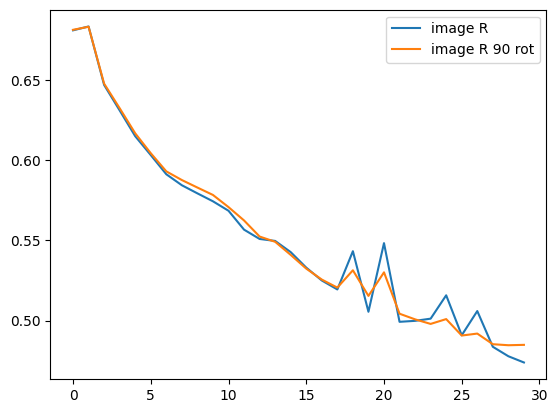

In [ ]:
plt.figure()
plt.plot(np.array(test_loss_c))
plt.plot(np.array(test_loss_rot_gdl_c))
plt.legend(['image R','image R 90 rot'])
plt.show()

# Compartion

compare three models resualt by testing models with rotated inpput

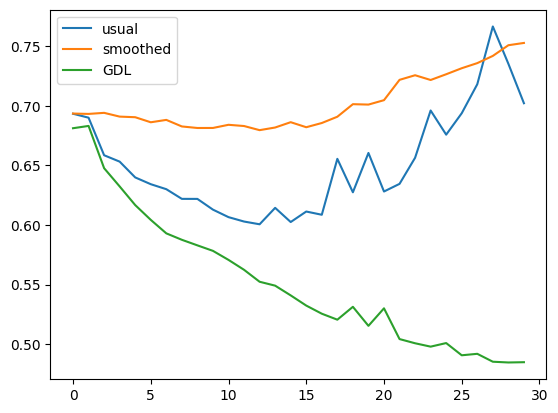

In [ ]:
plt.figure()
plt.plot(np.array(test_loss_rot_c))
plt.plot(np.array(test_loss_rot_s_c))
plt.plot(np.array(test_loss_rot_gdl_c))
plt.legend(['usual','smoothed','GDL'])
plt.show()

# Visualization

visualzing extracted features by basic model

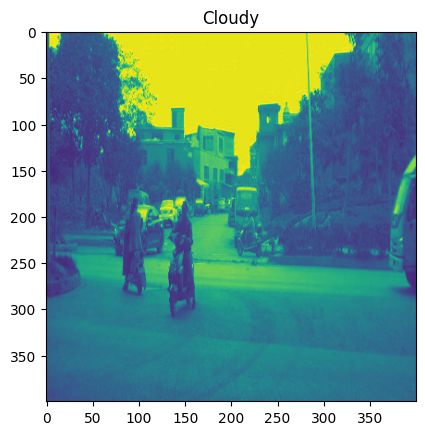

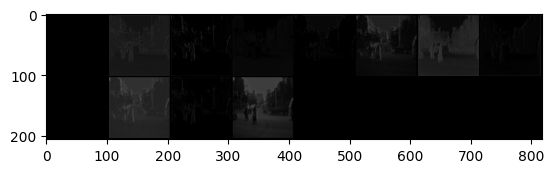

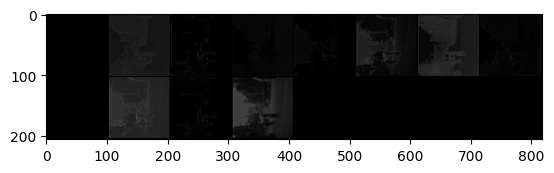

In [ ]:
dataiter = iter(train_loader)
imgL, imgR, labels = next(dataiter)
plt.figure()
if labels[0]==1:
  title='Cloudy'
else:
  title='Sunny'
X=imgL[0,:,:,:]
plt.title(title)
plt.imshow(X[0,:,:])

X = model.conv1(X.to(device))
X = nn.functional.relu(X)
# imshow(torchvision.utils.make_grid(X.reshape(3,1,400,400).cpu().detach()))

X = model.conv2(X)
X = nn.functional.relu(X)
X = model.pool1(X)
# imshow(torchvision.utils.make_grid(X.reshape(6,1,200,200).cpu().detach()))

X = model.conv3(X)
X = nn.functional.relu(X)
X = model.pool2(X)
imshow(torchvision.utils.make_grid(X.reshape(12,1,100,100).cpu().detach()))

X=rho(imgL[0,:,:,:],90)
X = model.conv1(X.to(device))
X = nn.functional.relu(X)
# imshow(torchvision.utils.make_grid(X.reshape(3,1,400,400).cpu().detach()))

X = model.conv2(X)
X = nn.functional.relu(X)
X = model.pool1(X)
# imshow(torchvision.utils.make_grid(X.reshape(6,1,200,200).cpu().detach()))

X = model.conv3(X)
X = nn.functional.relu(X)
X = model.pool2(X)
imshow(torchvision.utils.make_grid(X.reshape(12,1,100,100).cpu().detach()))

visualzing extracted features by Smooth model

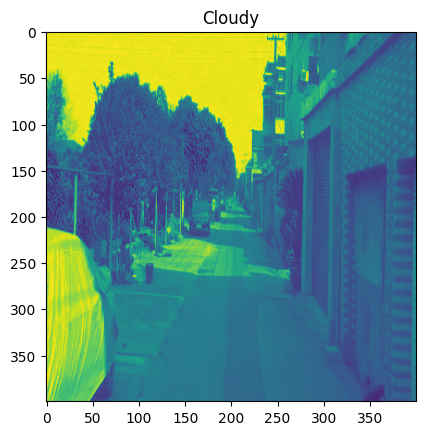

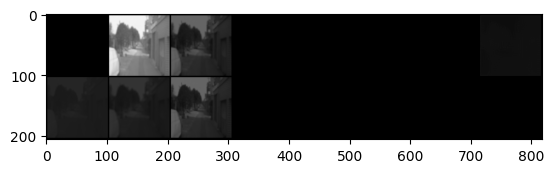

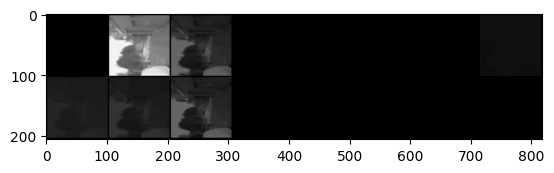

In [ ]:
X=imgL[0,:,:,:]
plt.title(title)
plt.imshow(X[0,:,:])
X = model1.conv1(X.to(device))
X = nn.functional.relu(X)
# imshow(torchvision.utils.make_grid(X.reshape(3,1,400,400).cpu().detach()))
X = model1.conv2(X)
X = nn.functional.relu(X)
X = model1.pool1(X)
# imshow(torchvision.utils.make_grid(X.reshape(6,1,200,200).cpu().detach()))
X = model1.conv3(X)
X = nn.functional.relu(X)
X = model1.pool2(X)
imshow(torchvision.utils.make_grid(X.reshape(12,1,100,100).cpu().detach()))
X=rho(imgL[0,:,:,:],90)
X = model1.conv1(X.to(device))
X = nn.functional.relu(X)
# imshow(torchvision.utils.make_grid(X.reshape(3,1,400,400).cpu().detach()))
X = model1.conv2(X)
X = nn.functional.relu(X)
X = model1.pool1(X)
# imshow(torchvision.utils.make_grid(X.reshape(6,1,200,200).cpu().detach()))
X = model1.conv3(X)
X = nn.functional.relu(X)
X = model1.pool2(X)
imshow(torchvision.utils.make_grid(X.reshape(12,1,100,100).cpu().detach()))

visualzing extracted features by invariant model

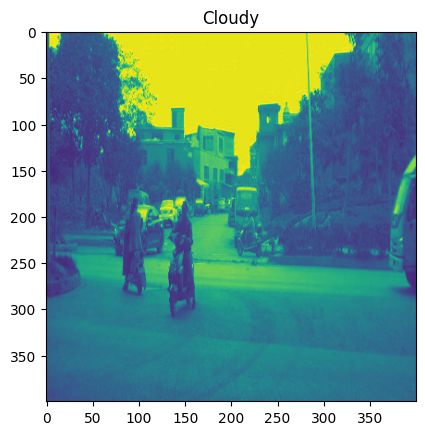

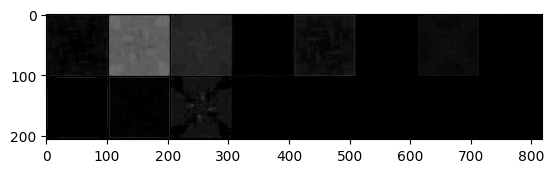

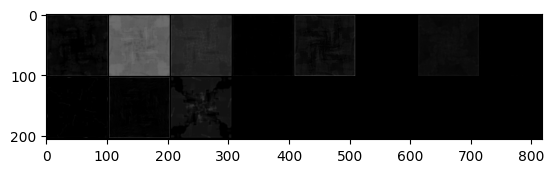

In [ ]:
X=imgL[0,:,:,:]
plt.title(title)
plt.imshow(X[0,:,:])
X = model2.conv1(X.to(device))
X = MaxPoolG0(X)
X = nn.functional.relu(X)
# imshow(torchvision.utils.make_grid(X.reshape(3,1,400,400).cpu().detach()))
X = model2.conv2(X)
X = nn.functional.relu(X)
X = model2.pool1(X)
# imshow(torchvision.utils.make_grid(X.reshape(6,1,200,200).cpu().detach()))
X = model2.conv3(X)
X = nn.functional.relu(X)
X = model2.pool2(X) # 32 x 100 x 150
X = InvPoolG(X)
imshow(torchvision.utils.make_grid(X.reshape(12,1,100,100).cpu().detach()))
X=rho(imgL[0,:,:,:],90)
X = model2.conv1(X.to(device))
X = MaxPoolG0(X)
# imshow(torchvision.utils.make_grid(X.reshape(3,1,400,400).cpu().detach()))
X = nn.functional.relu(X)
X = model2.conv2(X)
X = nn.functional.relu(X)
X = model2.pool1(X)
# imshow(torchvision.utils.make_grid(X.reshape(6,1,200,200).cpu().detach()))
X = model2.conv3(X)
X = nn.functional.relu(X)
X = model2.pool2(X) # 32 x 100 x 150
X = InvPoolG(X)
imshow(torchvision.utils.make_grid(X.reshape(12,1,100,100).cpu().detach()))